Several weeks back, I [posted some work](https://alphascientist.com/investor_flows.html) I had done on ETF fund flows and what they could tell us about how investors, on average, fare with respect to timing their entries and exits.  

_TL;DR:_  Most investors are terrible at timing inflows and outflows to the market.  They badly trail benchmarks because they tend to pile in near the top and exit the markets near the bottom.

The consistently correct strategy is to do the exact opposite of the bulk of investors.  In other words, buy when investors are pulling money out of the market, sell when they're piling in.  

Since the first 11 days of October have been rather active, I thought I'd take the occasion to build on the prior article with an update of fund flows month-to-date.  Contrarians may find some cause to "go against the flow". 

I won't go into much detail on the nuts and bolts of fund flows.  For that, please see the aforementioned [prior post](https://alphascientist.com/investor_flows.html).

In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

### Proprietary libraries
import sys
sys.path.append('/anaconda2/') # either place your config.py in this path, or add another sys.path.append() pointing to your path for config.py
import config ## TODO: place file called config.py in the /anaconda2/ folder

sys.path.append(config.REPO_ROOT+'data/') #Chad: Home
from prices.eod import iqfeed
from prices.eod.read import get_adjustment_factors

## Function to load prices and adjust dividends
def make_data(symbols):
    
    price = iqfeed.read_etf_daily(symbols)
    so = iqfeed.read_etf_so(symbols) #shares outstanding
    df = price[['close']].join(so)
    df.loc[df.so==0,'so'] = None
    df.so = df.so.ffill() # handle days of unreported shares out 
    df = df[df.so>0]

    adj_factors = get_adjustment_factors(symbols).stack()
    adj_factors.name = 'adj_factors'

    df['close_adj'] = df.close * adj_factors
    df['daily_ret_adj'] = df.close_adj.groupby(level='symbol').pct_change()
    df['log_ret_adj'] = np.log(df.close_adj).groupby(level='symbol').diff()
    df['flow'] = np.log(df.so).groupby(level='symbol').diff()
    df['mkt_cap_adj'] = df.so*df.close_adj

    # catch outliers
    #df = df[df.daily_ret_adj.abs()<0.25] # daily price changes of >25%
    #df = df[df.so.pct_change().abs()<0.50] # shares outstanding change of >50%

    # standardize time frame
    df = df.xs(slice('2017-12-01',None),level='date',drop_level=False)
    
    return df.copy()


Here's a quick peek at what the data looks like, using SPY as an example.  

            close_adj           so  daily_ret_adj      flow
date                                                       
2018-10-05     287.82  965032128.0      -0.005597 -0.001657
2018-10-08     287.82  974532096.0       0.000000  0.009796
2018-10-09     287.40  967732096.0      -0.001459 -0.007002
2018-10-10     278.30  972782144.0      -0.031663  0.005205
2018-10-11     272.17  976032128.0      -0.022027  0.003335


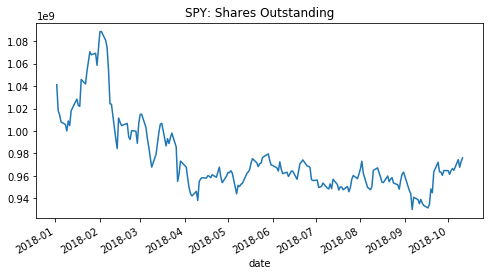

In [88]:
## Example: SPY
# close_adj: closing price, adjusted for divs/splits (if applicable)
# so: shares outstanding
# daily_ret_adj: daily return (0.01 is 1%) on adjusted prices
# flow: log percent change to shares outstanding.  In other words, amount invested (redeemed) as a (log) percent of market cap
df = make_data(['SPY'])
df=df.xs('SPY',level='symbol')
df['2018':].so.plot(title='SPY: Shares Outstanding',figsize=(8,4))
print(df[['close_adj','so','daily_ret_adj','flow']].tail())



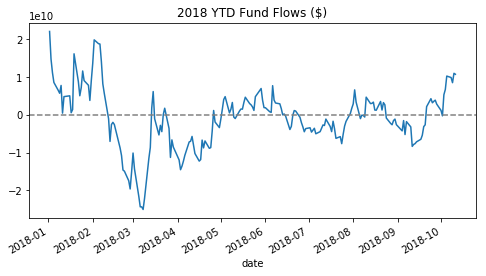

In [89]:
(df.flow*df.mkt_cap_adj).rolling(21).sum().plot(title='2018 YTD Fund Flows ($)',figsize=(8,4))
plt.axhline(y=0.0,color='grey',ls='--')

## Equity Indices
I'll start with the major indices - S&P 500, Russell 2K, Nasdaq 100, and Vanguard Total World index.  And yes, I intentionally ignored the Dow.  It's not a real index.  If we all ignore it, perhaps it'll go away.   

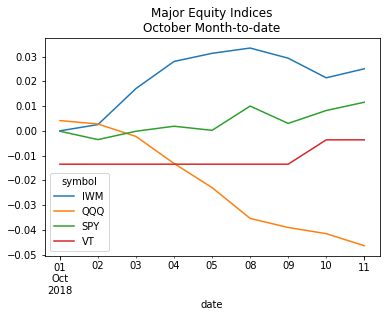

In [90]:
symbols = ['SPY','IWM','QQQ','VT']
df = make_data(symbols).sort_index().loc['2018-10']
df.flow.unstack().cumsum().plot(title="Major Equity Indices\nOctober Month-to-date")

Cumulatively, `QQQ` has had major outflows but the other three have seen measurable _inflows_ over the month to date.  Surprising... 

## Sectors
Next, we'll look at sectors like Consumer Discretionary, Technology, Materials, Energy, Healthcare, Utilities, Industrials, and Consumer Staples.  

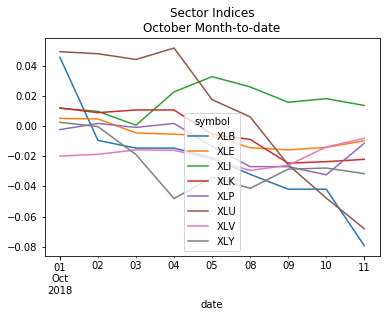

In [74]:
symbols = ['XLY','XLK','XLB','XLE','XLV','XLU','XLI','XLP']
df = make_data(symbols).sort_index().loc['2018-10']
df.flow.unstack().cumsum().plot(title="Sector Indices\nOctober Month-to-date")

Here, only `Industrials` have had positive flows in October.  `Utilities` and `Materials` have had >6% outflows each.   

## Country/Regional
Third, we'll look at countries and regions including `Australia`, `Germany`, `Japan`, `Canada`, `China`, and `Emerging Markets`.

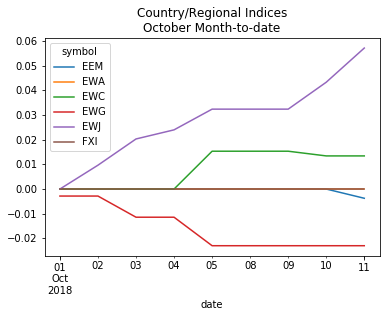

In [73]:
symbols = ['EWA','EWG','EWJ','EWC','FXI','EEM']

df = make_data(symbols).sort_index().loc['2018-10']
df.flow.unstack().cumsum().plot(title="Country/Regional Indices\nOctober Month-to-date")

Here, only `Germany` had negative flows, but rather limited.  `Japan` has gained substantial assets.

## Fixed Income
Finally, we'll look at major fixed income funds including `iShares Aggregate`, `20+ year Treasury`, `10 year Treasury`, `Municipal`, `High Yield/Junk`, `Corporate (investment grade)`. 

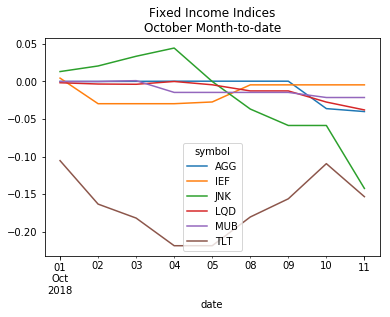

In [84]:
symbols = ['AGG','TLT','IEF','MUB','JNK','LQD']

df = make_data(symbols).sort_index().loc['2018-10']
df.flow.unstack().cumsum().plot(title="Fixed Income Indices\nOctober Month-to-date")

Ding, ding, ding!  Both long treasurys (TLT) and Junk bonds (JNK) have shed almost 15% of assets this month alone. Junk has seen outflows of almost 20% from the high water mark one week ago (Oct 4th), while long bonds seemed to have greatest redemptions in the first few days of the month.  

To put this in context, below is a chart of these ETFs during all of 2018 YTD - I'll throw in JNK's close cousin HYG for comparison.  

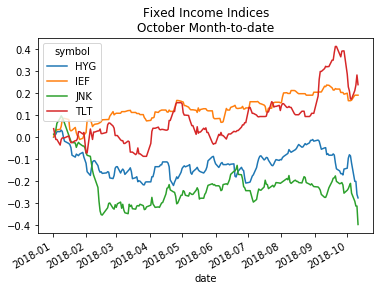

In [85]:
symbols = ['JNK','HYG','IEF','TLT']

df = make_data(symbols).sort_index().loc['2018']
df.flow.unstack().cumsum().plot(title="Fixed Income Indices\nOctober Month-to-date")

This month's redemption appears to be an acceleration of a longer term trend for junk, while it appears to be a short term reversal for treasurys.  

### Summary
Quick and dirty, we see that: 
* Equities have _not_ had outflows this week, despite what you might have expected.  
* Sector funds have, by and large, seen outflows - especially materials and industrials
* Japan has seen inflows
* Junk bonds and long treasurys have each seen double-digit outflows thus far in October.  

Contrarians may see these flows and consider loading up on materials, industrials, junk bonds and long treasurys.  This is not investment advice...


### One last thing...
If you've found this post useful or enlightening, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).  

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.  